In [48]:
# # Mount the Google drive onto Colab Virtual Environment
# from google.colab import drive
# drive.mount('/content/drive')
root = '.'
# root = '/content/drive/My Drive/English Dataset'

In [49]:
from __future__ import print_function
import collections
import math
import numpy as np
import os
import random
import tensorflow as tf
import zipfile
from six.moves import range
from six.moves.urllib.request import urlretrieve
import pandas as pd
import pickle

In [50]:
filename = os.path.join(root, 'mono.ma')

In [51]:
def read_data(filename):
    words = list()
    
    with open(filename) as f:
        c = tf.compat.as_str(f.read(1))
        
        while c:
            word = ''
            
            while c != ' ':
                word += c
                
                c = tf.compat.as_str(f.read(1))
            
            words.append(word)
                
            c = tf.compat.as_str(f.read(1))
            
    return words

words = read_data(filename)
print("Data size %d" % len(words))

Data size 155764


In [52]:
len(set(words))

12695

In [53]:
vocabulary_size = len(set(words)) +1

def build_dataset(words):
    count = [['UNK', -1]]
    count.extend(collections.Counter(words).most_common(vocabulary_size-1))
    dictionary = dict()
    
    for word, _ in count:
        dictionary[word] = len(dictionary)
    
    data = list()
    unk_count = 0
    
    for word in words:
        if word in dictionary:
            index = dictionary[word]
        else:
            index = 0
            unk_count += 1
        data.append(index)
    
    count[0][1] = unk_count
    
    reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
    return data, count, dictionary, reverse_dictionary

data, count, dictionary, reverse_dictionary = build_dataset(words)
print("Most common words (+UNK)", count[:5])
print("Sample data", data[:10])
del words

Most common words (+UNK) [['UNK', 0], ('आहे', 7739), ('मी', 5021), ('का', 3454), ('मला', 3193)]
Sample data [579, 6981, 6982, 6983, 6984, 75, 2210, 745, 6985, 3236]


In [54]:
data_index = 0

def generate_batch(batch_size, num_skips, skip_window):
    global data_index
    assert batch_size % num_skips == 0
    assert num_skips <= 2 * skip_window
    
    batch = np.ndarray(shape=(batch_size), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    span = 2 * skip_window + 1
    buffer = collections.deque(maxlen=span)
    
    for _ in range(span):
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    
    for i in range(batch_size // num_skips):
        target = skip_window
        targets_to_avoid = [skip_window]
        
        for j in range(num_skips):
            while target in targets_to_avoid:
                target = random.randint(0, span-1)
            targets_to_avoid.append(target)
            batch[i * num_skips + j] = buffer[skip_window]
            labels[i * num_skips + j, 0] = buffer[target]
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    return batch, labels

print("Data:", [reverse_dictionary[di] for di in data[:8]])

for num_skips, skip_window in [(2, 1), (4, 2)]:
    data_index = 0
    batch, labels = generate_batch(batch_size=8, num_skips=num_skips, skip_window=skip_window)
    print("\nwith num_skips = %d and skip_window = %d:" % (num_skips, skip_window))
    print("    batch:", [reverse_dictionary[bi] for bi in batch])
    print("    labels:", [reverse_dictionary[di] for di in labels.reshape(8)])

Data: ['जा', 'पळ', 'धाव', 'पळा', 'धावा', 'कोण', 'वाह', 'आग']

with num_skips = 2 and skip_window = 1:
    batch: ['पळ', 'पळ', 'धाव', 'धाव', 'पळा', 'पळा', 'धावा', 'धावा']
    labels: ['जा', 'धाव', 'पळ', 'पळा', 'धावा', 'धाव', 'पळा', 'कोण']

with num_skips = 4 and skip_window = 2:
    batch: ['धाव', 'धाव', 'धाव', 'धाव', 'पळा', 'पळा', 'पळा', 'पळा']
    labels: ['जा', 'पळा', 'पळ', 'धावा', 'पळ', 'कोण', 'धाव', 'धावा']


In [55]:
batch_size = 128
embedding_size = 128
skip_window = 1
num_skips = 2
valid_size = 16
valid_window = 100
valid_examples = np.array(random.sample(range(valid_window), valid_size))
num_sampled = 64

graph = tf.Graph()

with graph.as_default(), tf.device('/cpu:0'):
    train_dataset = tf.placeholder(tf.int32, shape=[batch_size])
    train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
    valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
    
    embeddings = tf.Variable(tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
    softmax_weights = tf.Variable(tf.truncated_normal([vocabulary_size, embedding_size], stddev=1.0 / math.sqrt(embedding_size)))
    softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))
    
    embed = tf.nn.embedding_lookup(embeddings, train_dataset)
    loss = tf.reduce_mean(tf.nn.sampled_softmax_loss(weights=softmax_weights, biases=softmax_biases, inputs=embed,
                                                    labels=train_labels, num_sampled=num_sampled, num_classes=vocabulary_size))
    
    optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)
    
    norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keepdims=True))
    normalized_embeddings = embeddings / norm
    valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)
    similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))

In [44]:
num_steps = 100001
loss_list = list()

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print("Initialized")
    average_loss = 0
    
    for step in range(num_steps):
        batch_data, batch_labels = generate_batch(batch_size, num_skips, skip_window)
        feed_dict = {train_dataset:batch_data, train_labels:batch_labels}
        _, l = session.run([optimizer, loss], feed_dict=feed_dict)
        average_loss += l
        
        if step % 2000 == 0:
            if step > 0:
                average_loss = average_loss / 2000
            
            print("Average loss at step %d: %f" % (step, average_loss))
            loss_list.append(average_loss)
            
            average_loss = 0
        
        if step % 10000 == 0:
            sim = similarity.eval()
            for i in range(valid_size):
                valid_word = reverse_dictionary[valid_examples[i]]
                top_k = 8
                nearest = (-sim[i, :]).argsort()[1:top_k+1]
                log = 'Nearest to %s:' % valid_word
                for k in range(top_k):
                    close_word = reverse_dictionary[nearest[k]]
                    log = '%s %s,' % (log, close_word)
                print(log)
    final_embeddings = normalized_embeddings.eval()

Initialized
Average loss at step 0: 5.215744
Nearest to सक्रिय: उपसमुच्चय, मार्कअप, प्रणाली, मान, स्टार्टफास्ट, बीयरिंगः, सकेंगी, व्यवसाय,
Nearest to चाहिए: उपयोक्तानाम, सकते, एस्केलेटर, स्लाइडशो, संगीता, लायब्रेरीज़, अंकः, अत्यावश्यक,
Nearest to वीडियो: सीमांत, सरह, ब्रेक, चेकः, दबाकर, के, प्रेषक, प्राथमिकताः,
Nearest to कृपया: साराटोगा, सदस्य, एटीके, उनसे, चौडाई, जीपीएस, मुताबिक, नुस्खे,
Nearest to करने: स्पॉट, डाउनलोड्स, क्लटर, पूछने, आयडेंटीटी, सिर्फ, रेक्ट, स्टोर,
Nearest to लिए: हलः, भरना, फ्रेंच, सुनें, उन्नत, बैठने, जिनमें, दिनः,
Nearest to किसी: ब्लॉड, लेबल, रद्दी, गहराईश्रृंखला, ईमेलः, ताज़ा, आसानी, स्टॉक,
Nearest to में: वरीयताएं, टिकता, कारण, अवैध, कैरिबू, ईमेलः, व्यक्ति, दिलाई,
Nearest to नया: यू, डिसकेनक्ट, अनुपलब्ध, एकल, अतंरफलक, आईएम, फाइलो, यांत्रिकी,
Nearest to प्रोजेक्ट: प्रतिस्थापन, पड़ोसी, बुक, पूर्वदर्शक, ढूँढ़, स्केन, देर, ख़ाका,
Nearest to कोई: कार्लो, घराना, पत्ताः, परिवहन, पढ़ना, बडा, सर्वरः, होंगीः,
Nearest to करना: आन्तरिक, खड़ा, खंड, तभी, मॉडलः, बनाने, आपका

Average loss at step 52000: 1.481892
Average loss at step 54000: 1.607881
Average loss at step 56000: 1.488529
Average loss at step 58000: 1.584398
Average loss at step 60000: 1.484719
Nearest to सक्रिय: बन्द, पुनःभारित, चुनो, पुस्तचिह्नित, मैनुअल, कम्पाइल, मुस्कुराएँ, ट्रेस,
Nearest to चाहिए: चाहते, ट्रीमैप, खोजा, जिसको, सैलेट, मान्य, जाए, करके,
Nearest to वीडियो: डिवायस, ऑडियो, कंडीडेटः, गनू, संजीवित, आरडब्ल्यू, आडियो, गोरडोन्स,
Nearest to कृपया: रेकॉर्ड, साराटोगा, प्रस्तुतिकरण, डॉक, नुस्खे, कॉन्फ़िगर, कानफिगर, लाओ,
Nearest to करने: पढने, मध्य, टेम्पलेट, देने, भेज, होने, पूछता, उद्गम,
Nearest to लिए: सेटबाक्स, क्लोंडाइक, आइकन, डिजायनर, पेस्ट, कालम, टेम्पलेट, बढ़ने,
Nearest to किसी: होगाः, शुरु, एमडी, छांटें, स्ट्रीट, केटेलन, ऑउटबाउंड, महत्वपूर्ण,
Nearest to में: अप्रत्याशित, चार, थे, इथिइयोपिक, पाएं, अरेबिक, फ्रैम, भाषाएँ,
Nearest to नया: यांत्रिकी, इंच, ऑफ़, अनुपात, सकारात्मक, अपठित, यूरोपीय, शब्दकोश,
Nearest to प्रोजेक्ट: बिन्यासः, मोड्यूल, माड्यूल, साइटें, गतिः, परियोजना, जुड़ने, 

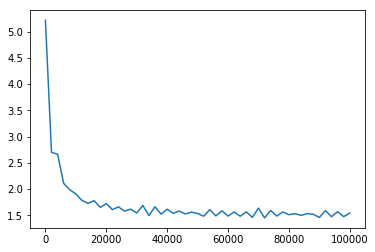

In [45]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(list(range(0, 100001, 2000)), loss_list)
plt.show()

In [46]:
output = {
    'embeddings': final_embeddings,
    'dictionary': dictionary,
    'reverse_dictionary': reverse_dictionary
}

In [47]:
with open(os.path.join(root, 'embeddings.hi'), 'wb') as f:
    pickle.dump(output, f)

In [56]:
num_steps = 100001
loss_list = list()

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print("Initialized")
    average_loss = 0
    
    for step in range(num_steps):
        batch_data, batch_labels = generate_batch(batch_size, num_skips, skip_window)
        feed_dict = {train_dataset:batch_data, train_labels:batch_labels}
        _, l = session.run([optimizer, loss], feed_dict=feed_dict)
        average_loss += l
        
        if step % 2000 == 0:
            if step > 0:
                average_loss = average_loss / 2000
            
            print("Average loss at step %d: %f" % (step, average_loss))
            loss_list.append(average_loss)
            
            average_loss = 0
        
        if step % 10000 == 0:
            sim = similarity.eval()
            for i in range(valid_size):
                valid_word = reverse_dictionary[valid_examples[i]]
                top_k = 8
                nearest = (-sim[i, :]).argsort()[1:top_k+1]
                log = 'Nearest to %s:' % valid_word
                for k in range(top_k):
                    close_word = reverse_dictionary[nearest[k]]
                    log = '%s %s,' % (log, close_word)
                print(log)
    final_embeddings = normalized_embeddings.eval()

Initialized
Average loss at step 0: 5.591136
Nearest to नकोस: मागणी, कमाल, गोळा, मुसलमानांचं, सुधारायचा, आपला, चेलो, मोठ्ठा,
Nearest to एक: कराल, लेकीसाठी, स्वादिष्ट, भौतिकशास्त्रवेत्ता, स्वीकारेन, धारधार, बहिणीसारख्या, बियरसाठी,
Nearest to त्यांना: खाशील, भौतिकशास्त्रवेत्ता, घंटा, गळपट्ट्यांची, साफ, खेळायचा, पोहणं, वाटतोय,
Nearest to आहोत: सायकलीने, स्टोव्ह, बाहुलीला, पिल्लू, बेईमान, मार्मलेडमध्ये, जितक्या, आठवतो,
Nearest to टॉमला: ड्यूवी, स्वतःसाठी, वाचलेलं, स्टार्स, सीमेचं, बोलेल, ईश्वराचा, एकपासून,
Nearest to घरी: उठली, फ्रांस, बघणार, सुरूवातीला, पाठवू, आणीबाणी, ब्लास्को, भाडे,
Nearest to माझा: विमानातून, मेलो, विचारली, बॉस्टनपासून, शिकायचे, चढली, टेकडीवरची, भावाचं,
Nearest to तर: वडिलांसारखा, असली, क्युबामध्ये, याविषयी, वापरून, माणसापेक्षा, ऑस्ट्रेलियाची, जॅक्सनच्या,
Nearest to ती: ग्रीकपासून, वेतन, वाजवायचो, डेटिंग, शिकवायला, घराची, वाढतोय, द्यायचा,
Nearest to नवीन: चेहरा, सभ्यतांचा, लान्झारोटेला, मासिकाचा, जास्तच, ईमेलने, माप, वाढली,
Nearest to नाव: धडपडू, युनाइटेड, चंद्रापेक्षा

Average loss at step 52000: 1.989117
Average loss at step 54000: 1.980908
Average loss at step 56000: 1.947209
Average loss at step 58000: 1.976285
Average loss at step 60000: 2.018465
Nearest to नकोस: नका, शकत, पाश्चात्य, भलं, वाचावं, भांडण, जीआयएफ, कुटुंबाला,
Nearest to एक: थोडीशी, वाढव, दगडफेक, सहापट, सेन्दाइच्या, क्रॉसला, कसतरीच, प्रकाशचित्रण,
Nearest to त्यांना: विनोद, त्याला, किन्शासा, बिलिअर्ड्ज, गमतीदार, साम्यवाद, मशीनमध्ये, विकली,
Nearest to आहोत: होतो, आहात, बेईमान, आवडायची, निघतेय, तुझ्यामुळे, वर्षीपासून, फ्राईज,
Nearest to टॉमला: माध्यमाने, वळवलं, भुतांच्या, वाचलेलं, रेस्टॉरंट, करताहात, करिमाने, शकली,
Nearest to घरी: आणतो, भाडे, डोमला, इथे, रेषेच्या, खोदत, कामात, घड्याळापेक्षा,
Nearest to माझा: तिचा, तुझा, टॉमचा, बाईकला, मक्केला, तुमचा, तिच्यापेक्षा, मेरीचा,
Nearest to तर: वातपरिरक्षी, फळं, सापडल्या, मोठाही, मिनिटांपूर्वी, आवडतेस, जॅझचं, जेवलो,
Nearest to ती: मित्रमैत्रिणींबरोबर, हत्तीला, भल्यासाठीच, चालतेय, नाकारल्या, पिऊ, रडण्यामुळे, डिस्को,
Nearest to नवीन: आरोग्याची, चा

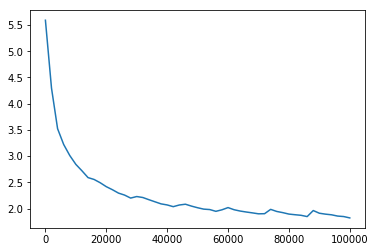

In [57]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(list(range(0, 100001, 2000)), loss_list)
plt.show()

In [58]:
output = {
    'embeddings': final_embeddings,
    'dictionary': dictionary,
    'reverse_dictionary': reverse_dictionary
}

In [59]:
with open(os.path.join(root, 'embeddings.ma'), 'wb') as f:
    pickle.dump(output, f)